## Pipeline de um processo de Deep Learning implementado em PyTorch:

    1. Preparar os Dados
    2. Definir o Modelo
    3. Treinar o Modelo
    4. Avaliar o Modelo
    5. Usar o Modelo


## **MLP para classificação multiclasse**
**Dataset Iris (flores)**
- Dataset de imagens para previsão da espécie da flor dadas as medidas das flores
- 3 classes com 50 instâncias cada
- Classes: Iris Setosa, Iris Versicolour e Iris Virginica
- 5 atributos: 4 para dimensões numéricas e o 5º a classe da flor

In [1]:
import torch
print(torch.__version__)

2.6.0+cu124


## Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

In [3]:
PATH = '../AP_Aula3_PL_datasets/iris.csv'

device = torch.device("cpu")

EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.01

## 1. Preparar os Dados

In [4]:
class CSVDataset(Dataset):
    def __init__(self, path):
        df = pd.read_csv(path, header=None)
        self.X = df.values[:, :-1]
        self.y = df.values[:, -1]
        self.X = self.X.astype('float32')
        self.y = LabelEncoder().fit_transform(self.y)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
 
    def get_splits(self, n_test=0.33):
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        return random_split(self, [train_size, test_size])
    
def prepare_data(path):
    dataset = CSVDataset(path)
    train, test = dataset.get_splits()
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    test_dl = DataLoader(test, batch_size=1024, shuffle=False)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
    return train_dl, test_dl, train_dl_all, test_dl_all

train_dl, test_dl,  train_dl_all, test_dl_all = prepare_data(PATH)

## 2. Definir o Modelo

In [5]:
from torchinfo import summary

class MLP(Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.hidden1 = Linear(n_inputs, 10)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.hidden2 = Linear(10, 8)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        self.hidden3 = Linear(8, 3)
        kaiming_uniform_(self.hidden3.weight, nonlinearity='sigmoid')
        self.act3 = Softmax()

 
    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.hidden3(X)
        X = self.act3(X)
        return X

model = MLP(4)
print(summary(model, input_size=(BATCH_SIZE, 4), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [32, 3]                   --
├─Linear: 1-1                            [32, 10]                  50
├─ReLU: 1-2                              [32, 10]                  --
├─Linear: 1-3                            [32, 8]                   88
├─ReLU: 1-4                              [32, 8]                   --
├─Linear: 1-5                            [32, 3]                   27
├─Softmax: 1-6                           [32, 3]                   --
Total params: 165
Trainable params: 165
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01


/home/eduardo/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/modules/module.py:1845: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return inner()


MLP(
  (hidden1): Linear(in_features=4, out_features=10, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=10, out_features=8, bias=True)
  (act2): ReLU()
  (hidden3): Linear(in_features=8, out_features=3, bias=True)
  (act3): Softmax(dim=None)
)

## 3. Treinar o Modelo

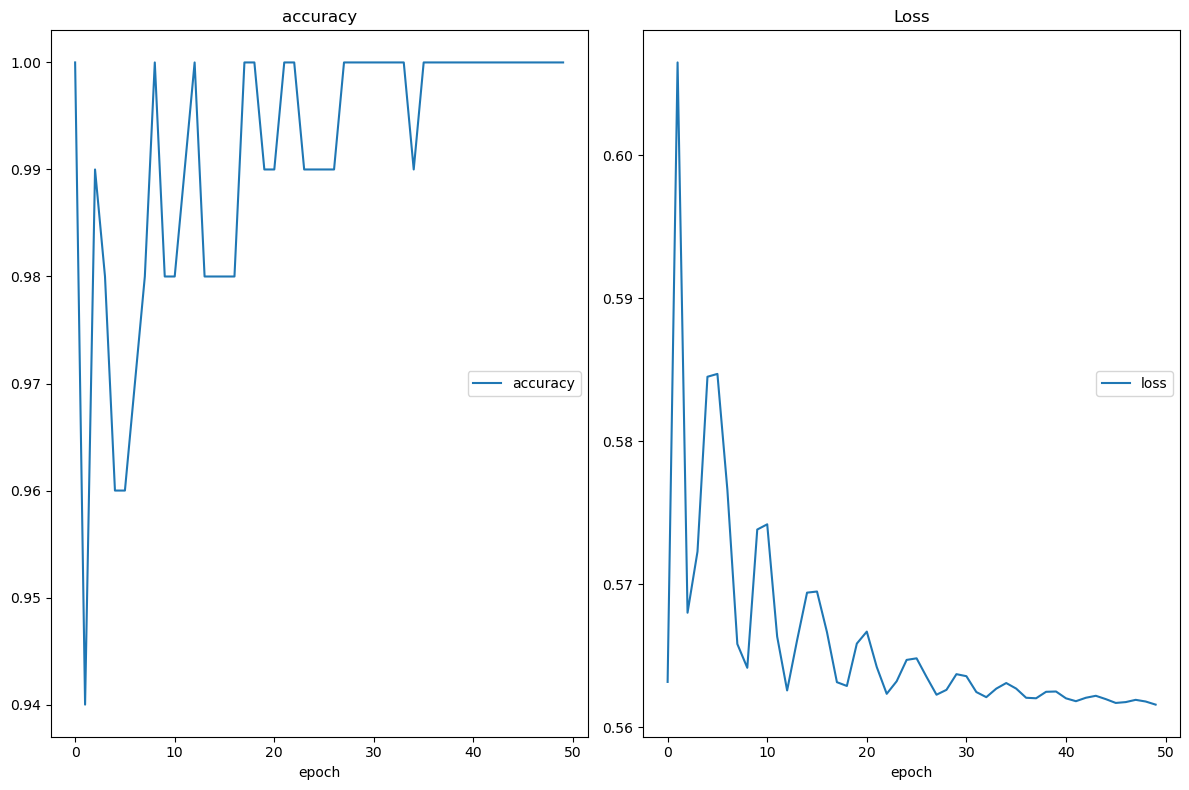

accuracy
	accuracy         	 (min:    0.940, max:    1.000, cur:    1.000)
Loss
	loss             	 (min:    0.562, max:    0.606, cur:    0.562)


In [19]:
from livelossplot import PlotLosses
EPOCHS = 50
LEARNING_RATE = 0.01

def train_model(train_dl, model):
    liveloss = PlotLosses()
    criterion = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    for epoch in range(EPOCHS):
        logs = {}
        epoch_loss  = 0 
        epoch_acc  = 0 
        for i, (inputs, labels) in enumerate(train_dl):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            acc = accuracy_score(labels.numpy(), np.argmax(outputs.detach().numpy(), axis=1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            epoch_acc += acc
        
        print(f'Epoch {epoch:03}: | Loss: {epoch_loss/len(train_dl):.5f} | Acc: {epoch_acc/len(train_dl):.3f}')      
        logs['loss'] = epoch_loss
        logs['accuracy'] = epoch_acc/len(train_dl)
        liveloss.update(logs)
        liveloss.send()

train_model(train_dl_all, model)

## 4. Avaliar o Modelo

Accuracy: 0.960

acertou:48 falhou:2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      0.87      0.93        15
           2       0.88      1.00      0.94        15

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50

[[20  0  0]
 [ 0 13  2]
 [ 0  0 15]]


/home/eduardo/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


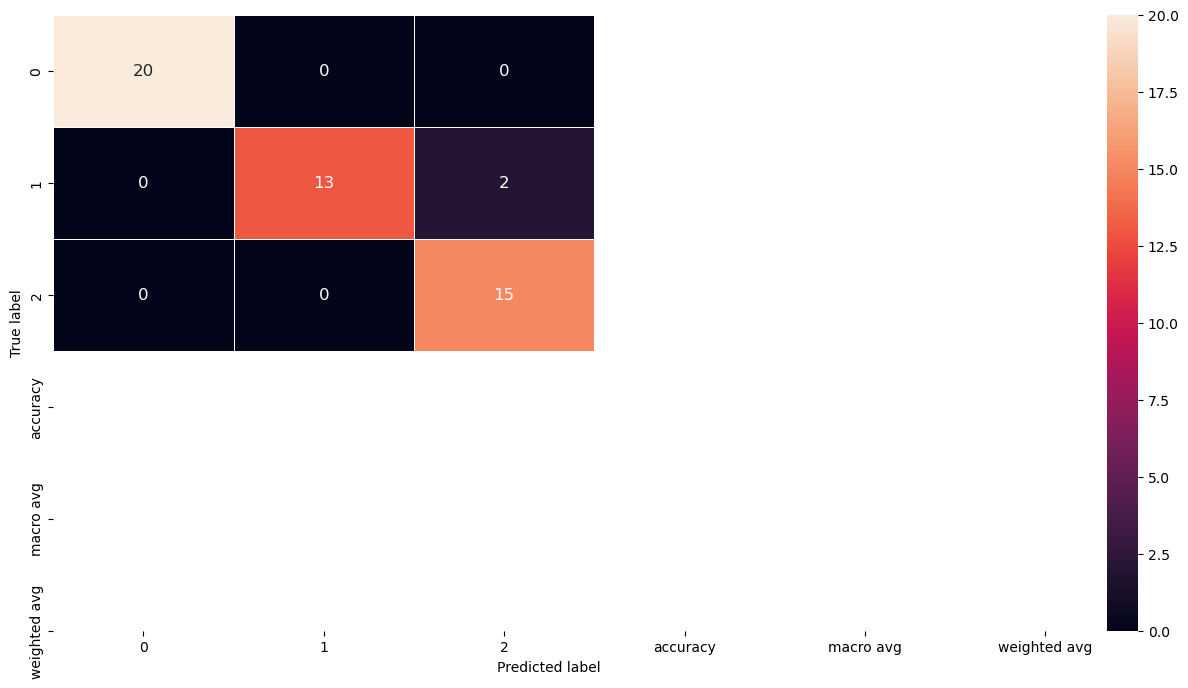

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for i, (inputs, labels) in enumerate(test_dl):
        yprev = model(inputs)
        yprev = yprev.detach().numpy()
        actual = labels.numpy()
        yprev = np.argmax(yprev, axis=1)
        actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        predictions.append(yprev)
        actual_values.append(actual)
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return actual_values, predictions

def display_confusion_matrix(cm,list_classes):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm,annot=True,xticklabels=list_classes,yticklabels=list_classes, annot_kws={"size": 12}, fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
actual_values, predictions = evaluate_model(test_dl, model)

acertou=0
falhou = 0
for r,p in zip(actual_values, predictions):
    if r==p: acertou+=1  
    else: falhou+=1

acc = accuracy_score(actual_values, predictions)
print(f'Accuracy: {acc:0.3f}\n')
print(f'acertou:{acertou} falhou:{falhou}')

print(classification_report(actual_values, predictions))
cr = classification_report(actual_values, predictions, output_dict=True)
list_classes=list(cr.keys())[0:10]
cm = confusion_matrix(actual_values, predictions)

print (cm)
display_confusion_matrix(cm,list_classes)

## 5. Usar o Modelo

In [21]:
def predict(row, model):
    row = Tensor([row])
    yprev = model(row)
    yprev = yprev.detach().numpy()
    return yprev

batch = next(iter(test_dl))
row, label = batch[0][0], batch[1][0]
row = row.numpy()

yprev = predict(row, model)
print('Predicted: %s (class=%d)' % (yprev, np.argmax(yprev)))

Predicted: [[9.9999988e-01 6.5542594e-08 1.7383845e-21]] (class=0)


/home/eduardo/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
